<img src="https://afs-services.com/wp-content/uploads/2025/09/pypricing_banner.png" alt="RV Banner" style="width: 100%; height: auto; display: block;">

### Importing

In [2]:
# general packages

import sys, os, json

import pandas as pd
import numpy as np
import plotly.graph_objs as go

# our library
repo_root = os.path.abspath("..")
sys.path.insert(0, repo_root)
from afslibrary import *

import db_tools

# beautiful_data = db_tools.BeautifulDataAFSStyle()
beautiful_data = db_tools.BeautifulDataAFSStyleXL()  # Uses xls instead of csv

d = DataFactory(beautiful_data)
cds_curve_data = beautiful_data.load_curve(
    "EDPFIN SR",
    start_date=pd.to_datetime("20200101", format="%Y%m%d"),
    end_date=pd.to_datetime("20211231", format="%Y%m%d"),
)
# discount_curves = d.import_discount_curves("ESTR", start_date="20200101", end_date="20221231")
calendars = d.import_calendar("Act360", "Act365")

import db_tools

db = db_tools.BeautifulDataAFSStyleXL()

# CRDC (Constant Rate Discount Curve)

In [3]:
constant_discount = CRDC(r=1, calendar=calendars["Act360"])

In [4]:
constant_discount.get_value(
    dates="20220101",
    future_dates=["20230101", "20230102"],
    calendar=calendars["Act360"],
)

array([0.36280532, 0.36179893])

In [5]:
constant_discount.get_value(
    dates="20220101",
    future_dates=["20230101", "20230102"],
    calendar=calendars["Act365"],
)

array([0.36787944, 0.36687293])

If no calendar is introduced, it uses the one of the discount curve. **This is a general feature of all discount curves.**

In [6]:
constant_discount.get_value(dates="20220101", future_dates=["20230101", "20230102"])

array([0.36280532, 0.36179893])

Tenor can be used instead of future_dates, but future_dates has preference in case of "conflict". **This is a general feature of all discount curves.**

In [7]:
constant_discount.get_value(
    dates="20220101", tenors=np.array([1, 1.01]), calendar=calendars["Act360"]
)

array([0.36787944, 0.36421898])

In [8]:
constant_discount.get_value(
    dates="20220101",
    future_dates=["20230101", "20230102"],
    tenors=np.array([1, 1.01]),
    calendar=calendars["Act360"],
)

array([0.36280532, 0.36179893])

# LCExpCurve

In [9]:
edp_curve = LCExpCurve(calendar=calendars["Act360"])

In [10]:
ticker = "EDPFIN SR"
discount_curve = "ESTR"
specs = cds_curve_data[ticker]["Specs"]
cds_spreads = cds_curve_data[ticker]["Data"]
cds_spreads = cds_spreads.rename(
    columns={column: specs.loc[column, "Tenor"] for column in cds_spreads.columns}
)
cds_spreads

""


In [11]:
edp_curve.fit(cds_spreads)
edp_curve.params[0]

""


# Cubic Spline

In [12]:
# Assume we have a CRDC object
crdc1 = CRDC(r=0.01, calendar=None)
crdc2 = CRDC(r=0.02, calendar=None)

# Create a pandas DataFrame with data generated from CRDC
dates = pd.date_range("2023-02-02", periods=2)
crdc = {}
crdc[dates[0]] = crdc1
crdc[dates[1]] = crdc2

tenors = np.linspace(0, 30, 5)  # Assuming tenors range from 0 to 30
random = 0.15 * np.random.rand(len(tenors))  # We add a random perturbation
data = pd.DataFrame(
    {
        date: np.full(
            len(tenors), crdc[date].get_value(dates=date, tenors=tenors) + random
        )
        for date in dates
    },
    index=tenors,
).transpose()
data

,0.0,7.5,15.0,22.5,30.0
2023-02-02,1.084154,1.026729,0.975736,0.857265,0.830334
2023-02-03,1.084154,0.959694,0.855846,0.696377,0.638328


Perturbation of yields for the whole curve

In [13]:
calendar = calendars["Act360"]
# Create instances of YieldCurve
curve = YieldCurve(calendar)
curve_pchip = YieldCurve(calendar)

# Fit the data
curve.fit(data)
curve_pchip.fit(data, method="yield_pchip")

# Plot the fitted data

# Create an array of tenors for which we want to get the curve values
tenors = np.linspace(0, 30)

# Figure for cubic spline perturbations
fig_per = go.Figure()


for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    curve.p = p
    curve_values = curve.get_value(dates="2023-02-02", tenors=tenors)
    curve_values

    curve_pchip.p = p
    curve_pchip_values = curve_pchip.get_value(dates="2023-02-02", tenors=tenors)
    curve_pchip_values

    # Create a plot
    fig = go.Figure()
    x_data = tenors
    y_data = curve_values
    y_data_pchip = curve_pchip_values
    x_original = data.columns.values
    y_original = data.loc["2023-02-02"].values
    fig.add_trace(go.Scatter(x=x_data, y=y_data, name="Fitted Data"))
    fig_per.add_trace(go.Scatter(x=x_data, y=y_data, name=f"Spline for p={p}"))
    fig.add_trace(go.Scatter(x=x_data, y=y_data_pchip, name="Fitted Data Pchip"))
    fig_per.add_trace(go.Scatter(x=x_data, y=y_data_pchip, name=f"Pchip for p={p}"))
    fig.add_trace(go.Scatter(x=x_original, y=y_original, name="Original Data"))

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot
    fig.write_html("curve_plot.html", auto_open=False)
fig_per.write_html("figure_perturbations.html", auto_open=False)

Now, the perturbation of the yield only happens for a given date

The perturbation at a given point propagates through the whole tenor structure, which is problematic, see Andersen and Piterbarg, Section 6.4 (Figure 6.7).

In [14]:
data.loc["2023-02-02"][22.5] * (
    1 - np.exp(-0.0005 * 22.5)
)  # Magnitude of the perturbation at tenor=22.5

0.00959018630995443

Some checks

In [15]:
curve.get_value(
    dates="2023-02-02",
    future_dates=["20230301", "20230302"],
    calendar=calendars["Act365"],
)

array([1.0831638 , 1.08312738])

In [16]:
curve_pchip.get_value(
    dates="2023-02-02",
    future_dates=["20230301", "20230302"],
    calendar=calendars["Act365"],
)

array([1.08359623, 1.08357558])

If no calendar is introduced, it uses the one of the discount curve. **This is a general feature of all discount curves.**

In [17]:
curve.get_value(dates="2023-02-02", future_dates=["20230301", "20230302"])

array([1.08315014, 1.08311322])

In [18]:
curve_pchip.get_value(dates="2023-02-02", future_dates=["20230301", "20230302"])

array([1.08358849, 1.08356755])

As the calendar is ``Act360`` this is equivalent to:

In [19]:
curve.get_value(
    dates="2023-02-02",
    future_dates=["20230301", "20230302"],
    calendar=calendars["Act360"],
)

array([1.08315014, 1.08311322])

In [20]:
curve_pchip.get_value(
    dates="2023-02-02",
    future_dates=["20230301", "20230302"],
    calendar=calendars["Act360"],
)

array([1.08358849, 1.08356755])

Tenor can be used instead of future_dates, but future_dates has preference in case of "conflict". **This is a general feature of all discount curves.**

In [21]:
curve.get_value(
    dates="2023-02-02", tenors=np.array([1, 1.01]), calendar=calendars["Act360"]
)

array([1.07186196, 1.07175049])

In [22]:
curve.get_value(
    dates="20230202",
    future_dates=["20230301", "20230302"],
    tenors=np.array([1, 1.01]),
    calendar=calendars["Act360"],
)

array([1.08315014, 1.08311322])

In [23]:
curve_pchip.get_value(
    dates="2023-02-02", tenors=np.array([1, 1.01]), calendar=calendars["Act360"]
)

array([1.0766588 , 1.07658437])

In [24]:
curve_pchip.get_value(
    dates="20230202",
    future_dates=["20230301", "20230302"],
    tenors=np.array([1, 1.01]),
    calendar=calendars["Act360"],
)

array([1.08358849, 1.08356755])

# Cubic Spline Swap Curve

This is the standard method in the ``data_factory`` module, for `irsw` curves.

In [25]:
discount_curves_bs = d.import_discount_curves(
    "EURIBOR",
    "USD LIBOR",
    "ESTR",
    start_date="20200101",
    end_date="20211231",
    method="bond_spline",
)

discount_curves_ys = d.import_discount_curves(
    "EURIBOR",
    "USD LIBOR",
    "ESTR",
    start_date="20200101",
    end_date="20211231",
    method="yield_spline",
)

discount_curves_flat = d.import_discount_curves(
    "EURIBOR",
    "USD LIBOR",
    "ESTR",
    start_date="20200101",
    end_date="20211231",
    method="flat_forwards",
)

discount_curves_pchip = d.import_discount_curves(
    "EURIBOR",
    "USD LIBOR",
    "ESTR",
    start_date="20200101",
    end_date="20211231",
    method="yield_pchip",
)


calendars = d.import_calendar("Act360", "Act365", "Cal30360")

To ask for values, there are standardized methods; we can pass on a single or multiple dates (as a list or a datetime index).

In [26]:
discount_curves_bs["EURIBOR"].get_value("20200202", "20210101")

array([1.00341559])

In [27]:
bond_spline_curve = discount_curves_bs["EURIBOR"]
yield_spline_curve = discount_curves_ys["EURIBOR"]
flat_forwards_curve = discount_curves_flat["EURIBOR"]
yield_pchip_curve = discount_curves_pchip["EURIBOR"]

# yield_spline_curve = CubicSplineSwapCurve(discount_curves_ys["EURIBOR"].calendar)
# data_ys = discount_curves_ys["EURIBOR"].interpolation_data
# yield_spline_curve.fit(data_ys, method="yield_spline")

In [28]:
# Plot of the forwards
date = "2020-02-02"
curve_bs = lambda t: bond_spline_curve.get_value(date, tenors=t)
curve_ys = lambda t: yield_spline_curve.get_value(date, tenors=t)
curve_flat = lambda t: flat_forwards_curve.get_value(date, tenors=t)
curve_pchip = lambda t: yield_pchip_curve.get_value(date, tenors=t)
curve_log_bs = lambda x: -np.log(curve_bs(x))
curve_log_ys = lambda x: -np.log(curve_ys(x))
curve_log_flat = lambda x: -np.log(curve_flat(x))
curve_log_pchip = lambda x: -np.log(curve_pchip(x))


def curve_forward(x, curve):
    h = 0.00001  # a small delta value to calculate the derivative, adjust if necessary
    return (curve(x + h) - curve(x)) / h  # finite difference method


x_values = np.linspace(0, 30, 1000)  # Change the range and number of points as needed
y_values_bs = curve_forward(x_values, curve_log_bs)
y_values_ys = curve_forward(x_values, curve_log_ys)
y_values_flat = curve_forward(x_values, curve_log_flat)
y_values_pchip = curve_forward(x_values, curve_log_pchip)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=y_values_bs, name="Fitted Data bond spline"))
fig.add_trace(go.Scatter(x=x_values, y=y_values_ys, name="Fitted Data yield spline"))
fig.add_trace(go.Scatter(x=x_values, y=y_values_flat, name="Fitted Data flat forwards"))
fig.add_trace(go.Scatter(x=x_values, y=y_values_pchip, name="Fitted Data pchip"))
fig.update_layout(title="Forwards Plot")
fig.write_html("forwards_plot.html", auto_open=False)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=x_values, y=curve_bs(x_values), name="Fitted Data bond spline")
)
fig.add_trace(
    go.Scatter(x=x_values, y=curve_ys(x_values), name="Fitted Data yield spline")
)
fig.add_trace(
    go.Scatter(x=x_values, y=curve_flat(x_values), name="Fitted Data flat forwards")
)
fig.add_trace(go.Scatter(x=x_values, y=curve_pchip(x_values), name="Fitted Data pchip"))
fig.update_layout(title="Curves Plot")
fig.write_html("curves_plot.html", auto_open=False)

In [29]:
y = {}  # Dictionary to store the values
date = "2020-02-02"


# Create an array of tenors for which we want to get the curve values


tenors = np.linspace(0, 30, 1000)


# Figure for cubic spline perturbations


fig_per = go.Figure()

curve_bs = lambda t: bond_spline_curve.get_value(date, tenors=t)
curve_ys = lambda t: yield_spline_curve.get_value(date, tenors=t)
curve_flat = lambda t: flat_forwards_curve.get_value(date, tenors=t)
curve_pchip = lambda t: yield_pchip_curve.get_value(date, tenors=t)


data_y = yield_spline_curve.zc_yields.loc["2020-02-02"]


data_b = np.exp(-data_y * data_y.index)


for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    yield_spline_curve.p = p

    bond_spline_curve.p = p

    flat_forwards_curve.p = p

    yield_pchip_curve.p = p

    curve_values_ys = curve_ys(tenors)
    curve_values_bs = curve_bs(tenors)
    curve_values_flat = curve_flat(tenors)
    curve_values_pchip = curve_pchip(tenors)

    # Create a plot

    fig = go.Figure()

    x_data = tenors

    x_original = data_b.index.values

    y_original = data_b.values
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_ys, name="Fitted Data, yield spline")
    )
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_bs, name="Fitted Data, bond spline")
    )
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_flat, name="Fitted Data, flat forwards")
    )
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_pchip, name="Fitted Data, yield pchip")
    )

    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_ys, name=f"Yield Spline for p={p}")
    )
    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_bs, name=f"Bond Spline for p={p}")
    )
    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_flat, name=f"Flat Forwards for p={p}")
    )
    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_pchip, name=f"Yield Pchip for p={p}")
    )
    fig.add_trace(
        go.Scatter(x=x_original, y=y_original, mode="markers", name="Original Data")
    )

    y[(p, "ys")] = curve_values_ys

    y[(p, "bs")] = curve_values_bs

    y[(p, "flat")] = curve_values_flat

    y[(p, "pchip")] = curve_values_pchip

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot

    fig.show()


fig_per.show()


# Figures for differences


list_str = ["ys", "bs", "flat", "pchip"]


for str in list_str:
    fig_per_diff = go.Figure()
    fig_per_diff.add_trace(
        go.Scatter(x=x_data, y=y[(1, str)] - y[(0, str)], name=f"$y_1-y_0$ {str}")
    )
    fig_per_diff.add_trace(
        go.Scatter(x=x_data, y=y[(0, str)] - y[(-1, str)], name=f"$y_0-y_{-1}$ {str}")
    )
    fig_per_diff.update_layout(
        title=f"Difference between perturbed curves",
        xaxis_title="Tenors",
        yaxis_title=f"Curves difference values",
    )

    fig_per_diff.show()

Now, a perturbation on a single tenor

In [30]:
data = bond_spline_curve.interpolation_data

bond_spline_curve.fit(data, delta_ind=20, method="bond_spline")

yield_spline_curve.fit(data, delta_ind=20, method="yield_spline")
flat_forwards_curve.fit(data, delta_ind=20, method="flat_forwards")
yield_pchip_curve.fit(data, delta_ind=20, method="yield_pchip")

In [31]:
data

,0.091667,0.275000,0.550000,1.100000,2.200000,3.300000,4.400000,5.500000,6.600000,7.700000,...,23.100000,24.200000,25.300000,26.400000,27.500000,28.600000,29.700000,30.800000,31.900000,33.000000
2020-01-31,-0.004994,-0.004323,-0.003718,-0.004027,-0.004092,-0.003910,-0.003636,-0.003278,-0.002854,-0.002338,...,0.003501,0.003613,0.003694,0.003748,0.003749,0.003608,0.003608,0.003597,0.003575,0.003698
2020-02-01,-0.005007,-0.004335,-0.003737,-0.004048,-0.004116,-0.003936,-0.003663,-0.003307,-0.002887,-0.002375,...,0.003427,0.003538,0.003617,0.003672,0.003672,0.003535,0.003534,0.003522,0.003499,0.003618
2020-02-02,-0.005021,-0.004347,-0.003756,-0.004069,-0.004140,-0.003962,-0.003690,-0.003336,-0.002919,-0.002412,...,0.003352,0.003462,0.003540,0.003596,0.003595,0.003462,0.003459,0.003447,0.003423,0.003538
2020-02-03,-0.005034,-0.004360,-0.003775,-0.004089,-0.004164,-0.003987,-0.003717,-0.003365,-0.002951,-0.002449,...,0.003277,0.003386,0.003463,0.003519,0.003517,0.003389,0.003385,0.003372,0.003348,0.003458
2020-02-04,-0.005047,-0.004372,-0.003793,-0.004110,-0.004189,-0.004013,-0.003744,-0.003394,-0.002983,-0.002486,...,0.003202,0.003310,0.003386,0.003443,0.003440,0.003316,0.003311,0.003297,0.003272,0.003377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-0.006395,-0.006293,-0.005995,-0.005340,-0.003345,-0.001752,-0.000742,-0.000011,0.000618,0.001200,...,0.005725,0.005685,0.005581,0.005555,0.005420,0.005367,0.005263,0.005153,0.005043,0.004887
2021-12-28,-0.006399,-0.006293,-0.005997,-0.005336,-0.003322,-0.001719,-0.000697,0.000039,0.000670,0.001255,...,0.005806,0.005767,0.005662,0.005638,0.005500,0.005453,0.005349,0.005240,0.005131,0.004974
2021-12-29,-0.006404,-0.006293,-0.006000,-0.005332,-0.003299,-0.001685,-0.000652,0.000088,0.000722,0.001309,...,0.005887,0.005849,0.005744,0.005721,0.005581,0.005538,0.005435,0.005327,0.005219,0.005062
2021-12-30,-0.006408,-0.006292,-0.006003,-0.005328,-0.003277,-0.001651,-0.000606,0.000138,0.000773,0.001364,...,0.005968,0.005931,0.005825,0.005803,0.005661,0.005623,0.005522,0.005415,0.005307,0.005149


In [32]:
y = {}  # Dictionary to store the values
# Create an array of tenors for which we want to get the curve values
tenors = np.linspace(0, 30, 1000)
# Figure for cubic spline perturbations
fig_per = go.Figure()

data_y = yield_spline_curve.zc_yields.loc["2020-02-02"]
data_b = np.exp(-data_y * data_y.index)

for p in np.array([-1, 0, 1]):
    # Compute curve values for all tenors
    yield_spline_curve.p = p
    bond_spline_curve.p = p
    flat_forwards_curve.p = p
    yield_pchip_curve.p = p

    curve_values_ys = yield_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values_bs = bond_spline_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values_flat = flat_forwards_curve.get_value(dates="2020-02-02", tenors=tenors)
    curve_values_pchip = yield_pchip_curve.get_value(dates="2020-02-02", tenors=tenors)

    # Create a plot
    fig = go.Figure()
    x_data = tenors
    x_original = data_b.index.values
    y_original = data_b.values
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_ys, name="Fitted Data, yield spline")
    )
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_bs, name="Fitted Data, bond spline")
    )
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_flat, name="Fitted Data, flat forwards")
    )
    fig.add_trace(
        go.Scatter(x=x_data, y=curve_values_pchip, name="Fitted Data, yield pchip")
    )

    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_ys, name=f"Yield Spline for p={p}")
    )
    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_bs, name=f"Bond Spline for p={p}")
    )
    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_flat, name=f"Flat Forwards for p={p}")
    )
    fig_per.add_trace(
        go.Scatter(x=x_data, y=curve_values_pchip, name=f"Yield Pchip for p={p}")
    )
    fig.add_trace(
        go.Scatter(x=x_original, y=y_original, mode="markers", name="Original Data")
    )

    y[(p, "ys")] = curve_values_ys
    y[(p, "bs")] = curve_values_bs
    y[(p, "flat")] = curve_values_flat
    y[(p, "pchip")] = curve_values_pchip

    # Add title and labels
    fig.update_layout(
        title=f"Curve values (p={p})", xaxis_title="Tenors", yaxis_title=f"Curve values"
    )

    # Show plot
    fig.show()
fig_per.show()

Plot of the forwards

In [33]:
# Plot of the forwards
date = "2020-02-02"
curve_bs = lambda t: bond_spline_curve.get_value(date, tenors=t)
curve_ys = lambda t: yield_spline_curve.get_value(date, tenors=t)
curve_flat = lambda t: flat_forwards_curve.get_value(date, tenors=t)
curve_pchip = lambda t: yield_pchip_curve.get_value(date, tenors=t)
curve_log_bs = lambda x: -np.log(curve_bs(x))
curve_log_ys = lambda x: -np.log(curve_ys(x))
curve_log_flat = lambda x: -np.log(curve_flat(x))
curve_log_pchip = lambda x: -np.log(curve_pchip(x))


def curve_forward(x, curve):
    h = 0.00001  # a small delta value to calculate the derivative, adjust if necessary
    return (curve(x + h) - curve(x)) / h  # finite difference method


x_values = np.linspace(0, 30, 1000)  # Change the range and number of points as needed
y_values_bs = curve_forward(x_values, curve_log_bs)
y_values_ys = curve_forward(x_values, curve_log_ys)
y_values_flat = curve_forward(x_values, curve_log_flat)
y_values_pchip = curve_forward(x_values, curve_log_pchip)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=y_values_bs, name="Fitted Data bond spline"))
fig.add_trace(go.Scatter(x=x_values, y=y_values_ys, name="Fitted Data yield spline"))
fig.add_trace(go.Scatter(x=x_values, y=y_values_flat, name="Fitted Data flat forwards"))
fig.add_trace(go.Scatter(x=x_values, y=y_values_pchip, name="Fitted Data pchip"))
fig.update_layout(title="Forwards Plot")
fig.show()

# SWI Curves

Inflation and inflation swaps data

In [34]:
cpi_ticker = "CPURNSA"
swi_ticker = "USSWIT"

Inflation as an underlying

In [35]:
assets = d.import_underlying(cpi_ticker)
dates = assets[cpi_ticker].get_dates()
dates0 = dates[dates <= "2009-06-30"]
dates0 = dates0[dates0 >= "20081230"]
dates0

DatetimeIndex(['2008-12-31', '2009-01-31', '2009-02-28', '2009-03-31',
               '2009-04-30', '2009-05-31', '2009-06-30'],
              dtype='datetime64[ns]', freq=None)

As we see, some data is interpolated within each month

In [36]:
assets = d.import_underlying(cpi_ticker)
dates = assets[cpi_ticker].get_dates()
dates1 = dates[dates >= "20221230"]
assets[cpi_ticker].get_value(dates1)

2022-12-30    326.4767
2023-01-02    326.4767
2023-01-03    326.4767
2023-01-04    326.4767
2023-01-05    326.4767
2023-01-06    326.4767
2023-01-09    326.4767
2023-01-10    326.4767
2023-01-11    326.4767
2023-01-12    326.4767
2023-01-13    326.4767
2023-01-16    326.4767
2023-01-17    326.4767
2023-01-18    326.4767
2023-01-19    326.4767
2023-01-20    326.4767
2023-01-23    326.4767
2023-01-24    326.4767
2023-01-25    326.4767
2023-01-26    326.4767
2023-01-27    326.4767
2023-01-30    326.4767
2023-01-31    329.0870
2023-02-01    329.0870
2023-02-02    329.0870
2023-02-03    329.0870
2023-02-06    329.0870
2023-02-07    329.0870
2023-02-08    329.0870
2023-02-09    329.0870
2023-02-10    329.0870
2023-02-13    329.0870
2023-02-14    329.0870
2023-02-15    329.0870
2023-02-16    329.0870
2023-02-17    329.0870
2023-02-20    329.0870
2023-02-21    329.0870
2023-02-22    329.0870
2023-02-23    329.0870
2023-02-24    329.0870
2023-02-27    329.0870
Name: CPURNSA Price, dtype: float6

Inflation swap rates, see Waldenberger or ``discount_curves.py`` module documentation for more details

In [37]:
swi_data = db.load_curve(swi_ticker, start_date="20080101", end_date="20090601")[
    swi_ticker
]


calendar = swi_data["Curve Specs"].loc["Calendar"]


swi_rates = swi_data["Data"].rename(
    columns={
        column: swi_data["Specs"].loc[column, "Tenor"]
        for column in swi_data["Data"].columns
    }
)


swi_rates /= 100


swi_rates["20081230":]

,1.1,2.2,3.3,4.4,5.5,6.6,7.7,8.8,9.9,11.0,16.5,22.0,27.5,33.0
2008-12-30,-0.040271,-0.026378,-0.010560,-0.006006,0.001182,0.004994,0.009735,0.012595,0.015774,0.017985,0.020526,0.020427,0.020119,0.022220
2008-12-31,-0.044105,-0.021730,-0.008921,-0.004351,0.000935,0.004466,0.008036,0.011066,0.015774,0.016786,0.019206,0.020867,0.022165,0.022858
2009-01-01,-0.039446,-0.021730,-0.011385,-0.004351,0.000660,0.004466,0.008036,0.011066,0.015774,0.016732,0.019206,0.020867,0.022165,0.022858
2009-01-02,-0.040271,-0.026378,-0.009433,-0.006006,0.001128,0.004994,0.009218,0.012826,0.015774,0.017985,0.020526,0.020427,0.020119,0.023182
2009-01-05,-0.039787,-0.026103,-0.008855,-0.005841,0.002612,0.005104,0.009317,0.012903,0.015851,0.018051,0.020581,0.020460,0.020141,0.023403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-05-26,-0.004015,0.004330,0.009559,0.013761,0.016885,0.019518,0.021558,0.023089,0.024430,0.025312,0.025999,0.026705,0.027328,0.029276
2009-05-27,-0.001540,0.006134,0.011055,0.015260,0.018596,0.021089,0.022994,0.024593,0.025660,0.026652,0.027280,0.028178,0.028689,0.030916
2009-05-28,-0.001320,0.006013,0.010422,0.014542,0.017919,0.020547,0.022054,0.023687,0.024838,0.025947,0.027170,0.027355,0.027835,0.030030
2009-05-29,0.001155,0.007252,0.011990,0.014916,0.018485,0.020922,0.022445,0.023987,0.025155,0.026041,0.027610,0.027216,0.027609,0.029871


We define the object 

In [38]:
curve = SWICurve(calendars[calendar], assets[cpi_ticker])

Season factors, see ``discount_curves.py`` module documentation for more details

In [39]:
curve.fit_seasonality_adjustment(regression_dates=["20100303"], no_regression_years=20)
curve.seasonal_factors

,1,2,3,4,5,6,7,8,9,10,11,12
2010-03-03 00:00:00,0.998543,0.998627,0.997356,0.99871,0.999781,0.999715,1.000481,1.000062,0.99957,1.000932,1.002749,1.003491


By construction, are normalized in the sense that their product equals one

In [40]:
curve.fit_seasonality_adjustment(regression_dates=["20220303"], no_regression_years=20)
curve.seasonal_factors.cumprod(axis=1)

,1,2,3,4,5,6,7,8,9,10,11,12
2010-03-03 00:00:00,0.998543,0.997172,0.994536,0.993253,0.993035,0.992752,0.993229,0.993291,0.992864,0.993789,0.996521,1.0
2022-03-03 00:00:00,0.998093,0.99556,0.992244,0.990672,0.989664,0.988982,0.989899,0.990414,0.990517,0.992351,0.996291,1.0


We can use the ``adjust_cpi`` method to deseasonalize the CPI

In [41]:
import plotly.graph_objects as go

dates_plot = dates[dates >= "20100101"]
dates_plot = dates_plot[dates_plot <= "20200101"]
month_cpi = assets[cpi_ticker].get_value(dates_plot).resample("M").last()
month_cpi_prev = month_cpi.shift()
month_cpi_prev.iloc[0] = assets[cpi_ticker].get_value(
    month_cpi.index[0] - pd.offsets.MonthEnd()
)
adjusted_cpi = curve.adjust_cpi(month_cpi, 30, last=False)
data = pd.DataFrame(
    data=np.array([month_cpi.values, adjusted_cpi.values]).T, index=month_cpi.index
)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data.iloc[:, 0], name="Original CPI"))
fig.add_trace(go.Scatter(x=data.index, y=data.iloc[:, 1], name="Adjusted CPI"))
fig.update_layout(
    title="CPI Comparison",
    xaxis_title="Date",
    yaxis_title="CPI",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
)
fig.show()

In [42]:
curve.fit(swi_rates, no_regression_years=10)
# curve.fit(swi_rates, delay_months=0)

Some checks comparing with ``USSWI.ipynb`` used for Rebonato Reading Group, correcting some mistakes in the previous implementation of the class

In [43]:
cpiT = curve.get_forward_value("20081230", tenors=np.arange(1, 16, 0.5) - 0.25)
cpiT

array([226.16921674, 222.40166248, 220.31468846, 220.50397366,
       222.90501487, 225.49166717, 226.45360918, 227.10950304,
       229.58180627, 233.42060094, 236.73273119, 239.32567675,
       242.7136295 , 247.43768635, 252.2631194 , 256.3394812 ,
       260.46940348, 265.53408719, 271.18661753, 276.71321095,
       281.87928811, 286.7326773 , 291.31380133, 295.6520213 ,
       299.77621736, 303.71526968, 307.4980584 , 311.15346368,
       314.71036567, 318.19764452])

In [44]:
cpi0 = curve.get_value("20081231")
cpi0

2008-12-31    231.2508
Name: CPURNSA Price, dtype: float64

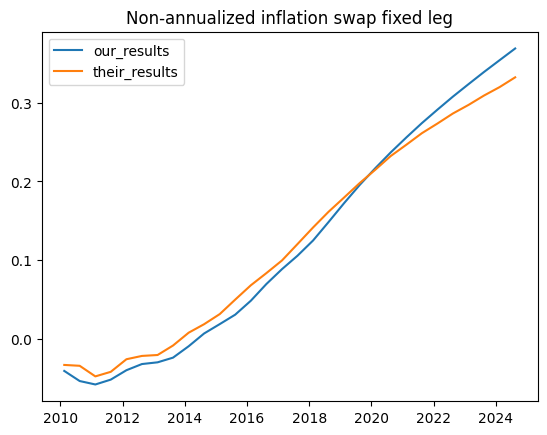

In [45]:
# OBTENEMOS LOS SWI QUE QUEREMOS SALVO LOS DOS PRIMEROS

displacement = 46 / 360

# CPI base: 30 de junio de 2022
cpi0 = assets[cpi_ticker].get_value("20081130").values[0]

# dates = pd.date_range("200901115", "20240215")
# cpdates = dates

# CPI proyectado:
cpiT = curve.get_forward_value("20081230", tenors=np.arange(1, 16, 0.5))
# swap rate anualizado
# print((cpiT/cpi0)**(1/(np.arange(1, 15, 0.5)+displacement))-1)
# print((cpiT/cpi0)-1)
# swap rate mercado

# COMPARISON 1

# Inflation_swap_total = [1.1856, 1.1638, 1.1480, 1.1467, 1.1307, 1.1376, 1.1566, 1.1616, 1.1630, 1.1773, 1.1967, 1.2095, 1.2248, 1.2466, 1.2683, 1.2866, 1.3058, 1.3304, 1.3556, 1.3792, 1.4009, 1.4225, 1.4427, 1.4635, 1.4806, 1.4979, 1.5126, 1.5277, 1.5407, 1.5548, 1.5676, 1.5823]
Inflation_swap = [
    1.1480,
    1.1467,
    1.1307,
    1.1376,
    1.1566,
    1.1616,
    1.1630,
    1.1773,
    1.1967,
    1.2095,
    1.2248,
    1.2466,
    1.2683,
    1.2866,
    1.3058,
    1.3304,
    1.3556,
    1.3792,
    1.4009,
    1.4225,
    1.4427,
    1.4635,
    1.4806,
    1.4979,
    1.5126,
    1.5277,
    1.5407,
    1.5548,
    1.5676,
    1.5823,
]
Inflation_swap_strikes = [x / 1.1875 - 1 for x in Inflation_swap]
# print(Inflation_swap_strikes)
idx = pd.date_range(
    start="2010-Feb-15", periods=30, freq=pd.DateOffset(months=6, day=15)
)
# Create a DataFrame with the values and the DatetimeIndex as the index
table_1 = pd.DataFrame(
    {"our_results": (cpiT / cpi0) - 1, "their_results": Inflation_swap_strikes},
    index=idx,
)
plt.plot(table_1["our_results"], label="our_results")
plt.plot(table_1["their_results"], label="their_results")
plt.legend()
plt.title("Non-annualized inflation swap fixed leg")
plt.show()
# print(table_1)


# COMPARISON 2

# val = ((cpiT/cpi0)*1.1875).tolist()
# #print([val[i] - Inflation_swap[i-1] for i in range(len(val))])
# idx = pd.date_range(start='2010-Feb-15', periods=30, freq=pd.DateOffset(months=6, day=15))
# # Create a DataFrame with the values and the DatetimeIndex as the index
# table_2 = pd.DataFrame({'our_results': val, 'their_results': Inflation_swap}, index=idx)
# plt.plot(table_2['our_results'], label = 'our_results')
# plt.plot(table_2['their_results'], label = 'their_results')
# plt.legend()
# plt.title('Table value')
# plt.show()
# print(table_2)